# License Plate Detection and Recognition using OpenCV and OCR

## License Plate Bounding Box Detection and IoU Calculation with YOLO Annotations
- **Preprocess Image**: Convert image to grayscale, apply noise reduction, and detect edges.
- **Bounding Box Detection**: Use contour detection to find and extract the license plate bounding box.
- **Load YOLO Annotations**: Convert YOLO bounding box format to corner coordinates.

In [ ]:
import os
import cv2
import numpy as np
import imutils
import matplotlib.pyplot as plt

# Function to detect bounding box using contour detection
def detect_license_plate_bbox(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Noise reduction and edge detection
    bfilter = cv2.bilateralFilter(gray, 11, 17, 17)
    edged = cv2.Canny(bfilter, 30, 200)

    # Finding contours
    keypoints = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(keypoints)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]
    
    # Locate the license plate based on contour shape (approx 4 points)
    location = None
    for contour in contours:
        approx = cv2.approxPolyDP(contour, 10, True)
        if len(approx) == 4:  # Likely rectangular
            location = approx
            break
    
    # Compute bounding box if location is found
    if location is not None:
        x, y = zip(*[point[0] for point in location])
        x_min, y_min = min(x), min(y)
        x_max, y_max = max(x), max(y)
        detected_bbox = [x_min, y_min, x_max, y_max]
        return detected_bbox  # Returns [x_min, y_min, x_max, y_max]
    else:
        return None

# Function to load YOLO label and compute IoU
def compute_iou(detected_bbox, yolo_bbox):
    x1_det, y1_det, x2_det, y2_det = detected_bbox
    x1_yolo, y1_yolo, x2_yolo, y2_yolo = yolo_bbox

    # Intersection
    x1_int = max(x1_det, x1_yolo)
    y1_int = max(y1_det, y1_yolo)
    x2_int = min(x2_det, x2_yolo)
    y2_int = min(y2_det, y2_yolo)

    if x1_int < x2_int and y1_int < y2_int:  # Valid intersection
        intersection = (x2_int - x1_int) * (y2_int - y1_int)
    else:
        intersection = 0

    # Union
    det_area = (x2_det - x1_det) * (y2_det - y1_det)
    yolo_area = (x2_yolo - x1_yolo) * (y2_yolo - y1_yolo)
    union = det_area + yolo_area - intersection

    # IoU calculation
    iou = intersection / union if union > 0 else 0
    return iou

# Directory paths (adjust as needed)
image_dir = "lpr.v1i.yolov8/train/images"
label_dir = "lpr.v1i.yolov8/train/labels"

ious = []
detected_images = 0  # Counter for detected images
total_images = 0  # Counter for all processed images

for filename in os.listdir(image_dir):
    img_path = os.path.join(image_dir, filename)
    label_path = os.path.join(label_dir, filename.replace('.jpg', '.txt'))
    
    # Detect bounding box using contour detection
    detected_bbox = detect_license_plate_bbox(img_path)
    if detected_bbox is None:
        continue  # Skip if bounding box is not detected
    
    detected_images += 1  # Increment detected image counter

    # Load YOLO bounding box
    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            line = f.readline().strip()
            bbox = list(map(float, line.split()))[1:]  # YOLO format [class, x_center, y_center, width, height]
            
            # Convert YOLO format to corner coordinates
            img = cv2.imread(img_path)
            h, w = img.shape[:2]
            x_center, y_center, width, height = bbox
            x1_yolo = int((x_center - width / 2) * w)
            y1_yolo = int((y_center - height / 2) * h)
            x2_yolo = int((x_center + width / 2) * w)
            y2_yolo = int((y_center + height / 2) * h)
            yolo_bbox = [x1_yolo, y1_yolo, x2_yolo, y2_yolo]
            
    else:
        print(f"Label file for {filename} not found. Skipping...")

    total_images += 1  # Increment total image counter



## Bounding Box Error Metrics: MSE and MAE

The following code defines two functions, `compute_mse` and `compute_mae`, for evaluating the accuracy of bounding box predictions in object detection. These functions calculate error metrics that assess the difference between detected bounding boxes and YOLO-predicted bounding boxes, normalized by the image dimensions.

- **Mean Squared Error (MSE)**: Computes the average of squared differences between detected and YOLO bounding box coordinates, giving greater weight to larger errors.
- **Mean Absolute Error (MAE)**: Computes the average of absolute differences, providing an intuitive measure of average discrepancy.

Each function accepts:
  - `detected_bbox`: Coordinates of the detected bounding box.
  - `yolo_bbox`: Coordinates of the YOLO bounding box.
  - `img_width` and `img_height`: Dimensions of the image for normalization.


In [29]:
import numpy as np

# Function for Normalized Mean Squared Error (MSE)
def compute_mse(detected_bbox, yolo_bbox, img_width, img_height):
    # Normalize detected and YOLO bounding boxes
    detected_bbox = np.array(detected_bbox) / np.array([img_width, img_height, img_width, img_height])
    yolo_bbox = np.array(yolo_bbox) / np.array([img_width, img_height, img_width, img_height])
    
    # Compute MSE
    mse = np.mean((detected_bbox - yolo_bbox) ** 2)
    return mse


# Function for Normalized Mean Absolute Error (MAE)
def compute_mae(detected_bbox, yolo_bbox, img_width, img_height):
    # Normalize detected and YOLO bounding boxes
    detected_bbox = np.array(detected_bbox) / np.array([img_width, img_height, img_width, img_height])
    yolo_bbox = np.array(yolo_bbox) / np.array([img_width, img_height, img_width, img_height])
    
    # Compute MAE
    mae = np.mean(np.abs(detected_bbox - yolo_bbox))
    return mae



### Loop Through Images:
  - Reads each image and label file.
  - Computes MSE and MAE values for each image, storing results in respective lists.

### Plotting Results
- **MSE and MAE Scatter Plots**: Displays MSE and MAE values for each processed image, visualizing individual errors to help identify outliers and patterns.
- **Average Error Calculation**: Calculates and prints average MSE and MAE values across all images, providing an overall accuracy metric.

### Average Metrics
- **Average MSE**: `0.07105532153613227`
- **Average MAE**: `0.19957567467063322`
et Example


Results for 2022-05-26-14_54_51-891818-jpg_jpg.rf.5a4d3a6d3bff8c7b73cd78e1ca6eb7f0.jpg - MSE: 0.15864662305843197, MAE: 0.37680288461538464
Results for 2022-05-26-15_05_12-314024-jpg_jpg.rf.2a6e496a29f6ab2a153c9c0a5d5f5655.jpg - MSE: 0.30774286936020706, MAE: 0.5486778846153846
Results for 2022-05-26-15_05_12-314024-jpg_jpg.rf.55f114f2a6bdae5f1b2e888d931e2f24.jpg - MSE: 0.0011455829326923073, MAE: 0.01983173076923076
Results for 2022-05-26-15_05_12-314024-jpg_jpg.rf.d08341d3ec1c5ee2deed886e1447fdfb.jpg - MSE: 2.8892381656804864e-06, MAE: 0.0012019230769230796
Results for 2022-05-26-15_05_19-241092-jpg_jpg.rf.24e03ff2ca6e603f9e343d0a8048ac82.jpg - MSE: 0.0001776881471893483, MAE: 0.012620192307692277
Results for 2022-05-26-15_05_19-241092-jpg_jpg.rf.3007f80d164c3bdcb9ce65c81414ed11.jpg - MSE: 0.033091889330621294, MAE: 0.1784855769230769
Results for 2022-05-26-15_05_22-716908-jpg_jpg.rf.6df1594f61794ad72c4b8a1c0e1b8027.jpg - MSE: 0.03632061298076923, MAE: 0.18149038461538458
Results for

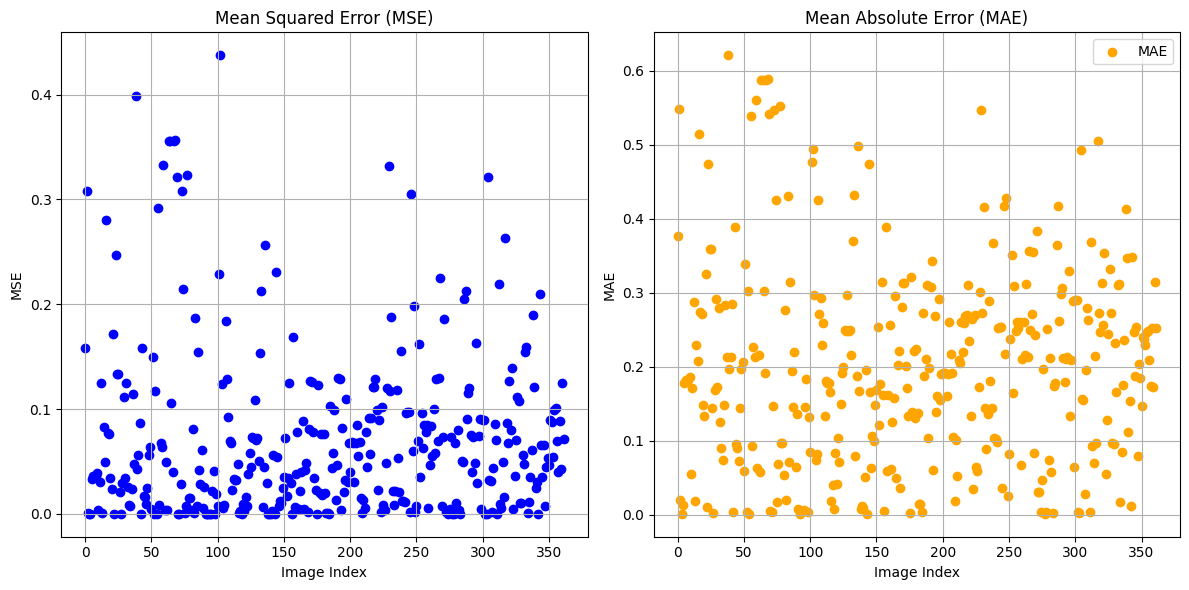

Average MSE: 0.07105532153613227
Average MAE: 0.19957567467063322


In [32]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Directory paths (adjust as needed)
image_dir = "lpr.v1i.yolov8/train/images"
label_dir = "lpr.v1i.yolov8/train/labels"

# Store results for plotting
mse_results = []
mae_results = []

# Function for Normalized Mean Squared Error (MSE)
def compute_mse(detected_bbox, yolo_bbox, img_width, img_height):
    detected_bbox = np.array(detected_bbox) / np.array([img_width, img_height, img_width, img_height])
    yolo_bbox = np.array(yolo_bbox) / np.array([img_width, img_height, img_width, img_height])
    mse = np.mean((detected_bbox - yolo_bbox) ** 2)
    return mse

# Function for Normalized Mean Absolute Error (MAE)
def compute_mae(detected_bbox, yolo_bbox, img_width, img_height):
    detected_bbox = np.array(detected_bbox) / np.array([img_width, img_height, img_width, img_height])
    yolo_bbox = np.array(yolo_bbox) / np.array([img_width, img_height, img_width, img_height])
    mae = np.mean(np.abs(detected_bbox - yolo_bbox))
    return mae

# Loop through images in the directory
for filename in os.listdir(image_dir):
    img_path = os.path.join(image_dir, filename)
    label_path = os.path.join(label_dir, filename.replace('.jpg', '.txt'))
    
    # Detect bounding box using contour detection
    detected_bbox = detect_license_plate_bbox(img_path)
    if detected_bbox is None:
        continue
    
    # Load YOLO bounding box
    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            line = f.readline().strip()
            bbox = list(map(float, line.split()))[1:]  # Assuming YOLO format [class, x_center, y_center, width, height]
            
            # Convert YOLO format to corner coordinates
            img = cv2.imread(img_path)
            h, w = img.shape[:2]
            x_center, y_center, width, height = bbox
            x1_yolo = int((x_center - width / 2) * w)
            y1_yolo = int((y_center - height / 2) * h)
            x2_yolo = int((x_center + width / 2) * w)
            y2_yolo = int((y_center + height / 2) * h)
            yolo_bbox = [x1_yolo, y1_yolo, x2_yolo, y2_yolo]
            
            # Compute metrics and store the results
            mse = compute_mse(detected_bbox, yolo_bbox, w, h)
            mae = compute_mae(detected_bbox, yolo_bbox, w, h)
            
            mse_results.append(mse)
            mae_results.append(mae)
           
            print(f"Results for {filename} - MSE: {mse}, MAE: {mae}")
    else:
        print(f"Label file for {filename} not found. Skipping...")



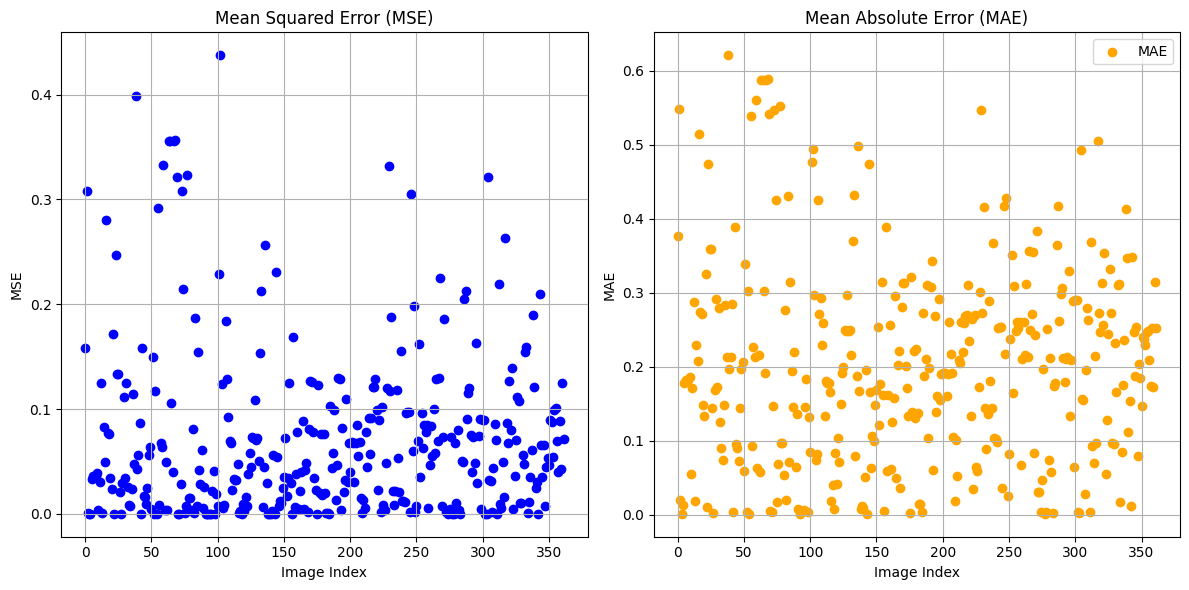

Average MSE: 0.07105532153613227
Average MAE: 0.19957567467063322


In [45]:
# Plot results
plt.figure(figsize=(12, 6))

# MSE Scatter Plot
plt.subplot(1, 2, 1)
plt.scatter(range(len(mse_results)), mse_results, label='MSE', color='blue')
plt.title("Mean Squared Error (MSE)")
plt.xlabel("Image Index")
plt.ylabel("MSE")
plt.grid(True)

# MAE Scatter Plot
plt.subplot(1, 2, 2)
plt.scatter(range(len(mae_results)), mae_results, label='MAE', color='orange')
plt.title("Mean Absolute Error (MAE)")
plt.xlabel("Image Index")
plt.ylabel("MAE")
plt.grid(True)

plt.tight_layout()
plt.legend()
plt.show()

# Calculate and print average metrics
if mse_results and mae_results:
    print(f"Average MSE: {np.mean(mse_results)}")
    print(f"Average MAE: {np.mean(mae_results)}")
else:
    print("No MSE or MAE values calculated.")


### Loop Through Images:
  - Reads each image and its corresponding label file.
  - Converts the YOLO bounding box from normalized to unnormalized (pixel) coordinates.
  - Computes the Intersection over Union (IoU) between the detected bounding box and the YOLO bounding box, storing results in the `iou_results` list.
  - Skips images where no bounding box is detected or the label file is missing.

### Plotting Results
- **IoU Calculation**: Computes IoU for each image, indicating the overlap between the detected bounding box and the YOLO ground truth bounding box.
- **Results Display**: Displays IoU values for each processed image, helping visualize detection accuracy.
  
### Average Metrics
- **Average IoU**: The script accumulates IoU values for valid detections and prints out the IoU for each processed image, showcasing the model's performance.


Results for 2022-05-26-15_05_12-314024-jpg_jpg.rf.55f114f2a6bdae5f1b2e888d931e2f24.jpg - IoU: 0.48474801061007955
Results for 2022-05-26-15_05_12-314024-jpg_jpg.rf.d08341d3ec1c5ee2deed886e1447fdfb.jpg - IoU: 0.9726027397260274
Results for 2022-05-26-15_05_19-241092-jpg_jpg.rf.24e03ff2ca6e603f9e343d0a8048ac82.jpg - IoU: 0.4583333333333333
Results for 2022-05-26-15_05_27-945093-jpg_jpg.rf.c2f837a5ffdcbd78bb8ecb5536f0a299.jpg - IoU: 0.39206349206349206
Results for 2022-05-26-15_06_00-293435-jpg_jpg.rf.2be99006b25643763947c30bdb4923d6.jpg - IoU: 0.5158371040723982
Results for 2022-05-26-15_28_44-511889-jpg_jpg.rf.d080030c083004667bcd13aaf16feeaf.jpg - IoU: 0.8771929824561403
Results for 2022-05-26-15_34_59-478852-jpg_jpg.rf.6b5a6af2243627177ea8d9f7d8985a7c.jpg - IoU: 0.5333333333333333
Results for 2022-05-26-16_14_13-913515-jpg_jpg.rf.2529aa2080e8bf678043a6f33693aa97.jpg - IoU: 0.7058823529411765
Results for 2022-05-26-16_14_13-913515-jpg_jpg.rf.b220f6f5461bd5039530d997b82d2649.jpg - IoU: 

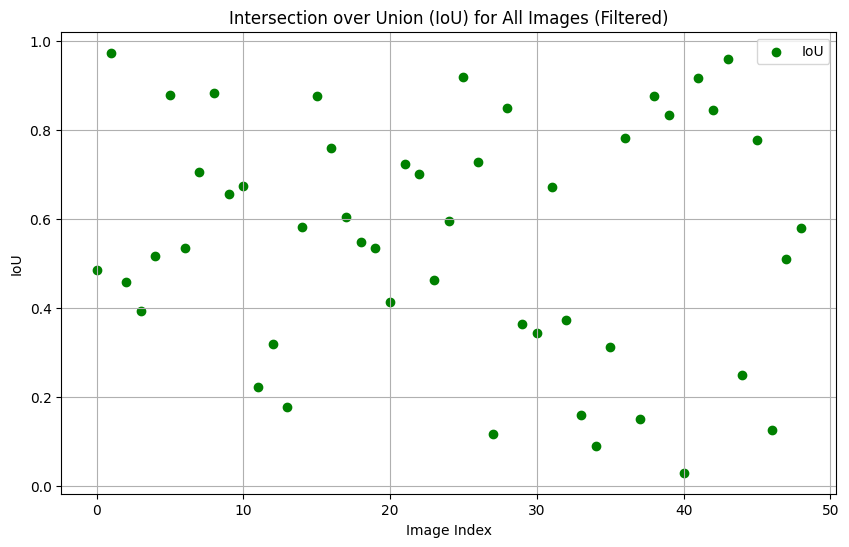

Average IoU (non-zero): 0.5553388219359513


In [35]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Function to convert YOLO normalized bbox to unnormalized (pixel) coordinates
def convert_to_unnormalized_bbox(yolo_bbox, image_shape):
    h, w = image_shape[:2]
    x_center, y_center, width, height = yolo_bbox
    x1 = int((x_center - width / 2) * w)
    y1 = int((y_center - height / 2) * h)
    x2 = int((x_center + width / 2) * w)
    y2 = int((y_center + height / 2) * h)
    return [x1, y1, x2, y2]

# Function to calculate IoU for unnormalized bounding boxes
def compute_iou_unnormalized(detected_bbox, yolo_bbox, image_shape):
    # Convert YOLO bbox to unnormalized coordinates
    yolo_bbox_unnormalized = convert_to_unnormalized_bbox(yolo_bbox, image_shape)
    
    x1_det, y1_det, x2_det, y2_det = detected_bbox
    x1_yolo, y1_yolo, x2_yolo, y2_yolo = yolo_bbox_unnormalized

    # Intersection
    x1_int = max(x1_det, x1_yolo)
    y1_int = max(y1_det, y1_yolo)
    x2_int = min(x2_det, x2_yolo)
    y2_int = min(y2_det, y2_yolo)

    if x1_int < x2_int and y1_int < y2_int:  # Valid intersection
        intersection = (x2_int - x1_int) * (y2_int - y1_int)
    else:
        intersection = 0

    # Union
    det_area = (x2_det - x1_det) * (y2_det - y1_det)
    yolo_area = (x2_yolo - x1_yolo) * (y2_yolo - y1_yolo)
    union = det_area + yolo_area - intersection

    # IoU calculation
    iou = intersection / union if union > 0 else 0
    return iou

# Directory paths (adjust as needed)
image_dir = "lpr.v1i.yolov8/train/images"
label_dir = "lpr.v1i.yolov8/train/labels"

# Store results for plotting
iou_results = []

# Loop through all images in the image directory
for filename in os.listdir(image_dir):
    img_path = os.path.join(image_dir, filename)
    label_path = os.path.join(label_dir, filename.replace('.jpg', '.txt'))
    
    # Detect bounding box using contour detection (assuming you have a detect_license_plate_bbox function)
    detected_bbox = detect_license_plate_bbox(img_path)  # Replace with your actual detection method
    if detected_bbox is None:
        continue  # Skip comparison if no bounding box is detected
    
    # Load YOLO bounding box only if detected bbox is found
    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            line = f.readline().strip()
            bbox = list(map(float, line.split()))[1:]  # Assuming YOLO format [class, x_center, y_center, width, height]
            
            # Convert YOLO format to corner coordinates
            img = cv2.imread(img_path)
            image_shape = img.shape
            yolo_bbox = bbox  # YOLO normalized bbox [x_center, y_center, width, height]
            
            # Compute IoU and store the result if it's greater than 0
            iou = compute_iou_unnormalized(detected_bbox, yolo_bbox, image_shape)
            if iou > 0.0:
                iou_results.append(iou)
                print(f"Results for {filename} - IoU: {iou}")
    else:
        print(f"Label file for {filename} not found. Skipping...")




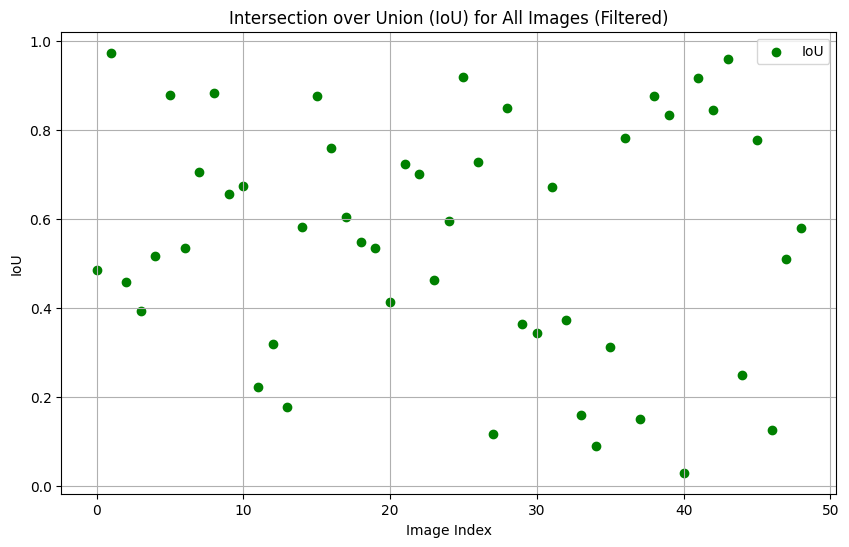

Average IoU (non-zero): 0.5553388219359513


In [46]:
# Plot results as a scatter plot (only non-zero IoUs)
plt.figure(figsize=(10, 6))
plt.scatter(range(len(iou_results)), iou_results, label='IoU', color='green')
plt.title("Intersection over Union (IoU) for All Images (Filtered)")
plt.xlabel("Image Index")
plt.ylabel("IoU")
plt.grid(True)
plt.legend()
plt.show()

# Calculate and print average IoU (only for non-zero values)
if iou_results:
    average_iou = np.mean(iou_results)
    print(f"Average IoU (non-zero): {average_iou}")
else:
    print("No non-zero IoU values found.")

### License Plate Recognition Process

1. **Preprocessing**: Convert image to grayscale, apply bilateral filter, and use Canny edge detection.
2. **Contour Detection**: Find largest quadrilateral contours to locate the license plate.
3. **Region Extraction**: Mask and crop the license plate area from the image.
4. **OCR**: Extract text from the cropped license plate using EasyOCR.
5. **Text Annotation**: Annotate the detected text on the original image and draw the bounding box.
6. **Display Result**: Show the annotated image with license plate text.

### Example Output
- **License Plate Detection**: License plate text and bounding box if detected.
- **Text Recognition**: OCR-extracted text displayed on the image.
- **Visualization**: Annotated final image with visible license plate text.


In [50]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import imutils
import easyocr

def recognize_license_plate(image_path):
    # Step 1: Load image and convert to grayscale
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Display the grayscale image
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(gray, cv2.COLOR_BGR2RGB))
    plt.title('Step 1: Grayscale Image')
    plt.axis('off')
    plt.show()

    # Step 2: Noise reduction and edge detection
    bfilter = cv2.bilateralFilter(gray, 11, 17, 17)
    edged = cv2.Canny(bfilter, 30, 200)
    
    # Display the edged image
    plt.figure(figsize=(10, 10))
    plt.imshow(edged, cmap='gray')
    plt.title('Step 2: Edge Detection')
    plt.axis('off')
    plt.show()

    # Step 3: Find contours and locate the license plate
    keypoints = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(keypoints)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]
    
    location = None
    for contour in contours:
        approx = cv2.approxPolyDP(contour, 10, True)
        if len(approx) == 4:
            location = approx
            break
    
    # Ensure a valid location was found
    if location is None:
        print("License plate not found.")
        return

    # Step 4: Mask the plate region and extract it
    mask = np.zeros(gray.shape, np.uint8)
    cv2.drawContours(mask, [location], 0, 255, -1)
    masked_img = cv2.bitwise_and(img, img, mask=mask)

    (x, y) = np.where(mask == 255)
    (x1, y1) = (np.min(x), np.min(y))
    (x2, y2) = (np.max(x), np.max(y))
    cropped_image = gray[x1:x2+1, y1:y2+1]
    
    # Display the masked region and cropped image
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(masked_img, cv2.COLOR_BGR2RGB))
    plt.title('Step 4: Masked Plate Region')
    plt.axis('off')
    plt.show()

    plt.figure(figsize=(10, 10))
    plt.imshow(cropped_image, cmap='gray')
    plt.title('Step 4: Cropped License Plate')
    plt.axis('off')
    plt.show()

    # Step 5: Use OCR to read the license plate text
    reader = easyocr.Reader(['en'])
    result = reader.readtext(cropped_image)
    
    if result:
        text = result[0][-2]
    else:
        print("Text could not be detected.")
        return

    # Step 6: Annotate the original image
    font = cv2.FONT_HERSHEY_SIMPLEX
    img_with_text = cv2.putText(img, text=text, org=(location[0][0][0], location[0][0][1]-10), 
                                fontFace=font, fontScale=1, color=(0, 255, 0), thickness=2, lineType=cv2.LINE_AA)
    img_with_text = cv2.rectangle(img_with_text, tuple(location[0][0]), tuple(location[2][0]), (0, 255, 0), 3)

    # Display the final image with the text and bounding box
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(img_with_text, cv2.COLOR_BGR2RGB))
    plt.title(f'Step 6: Annotated License Plate with Text: {text}')
    plt.axis('off')
    plt.show()

    # Print the final detected license plate text
    print(f"Detected License Plate Text: {text}")

# Example usage
# recognize_license_plate('path_to_your_image.jpg')


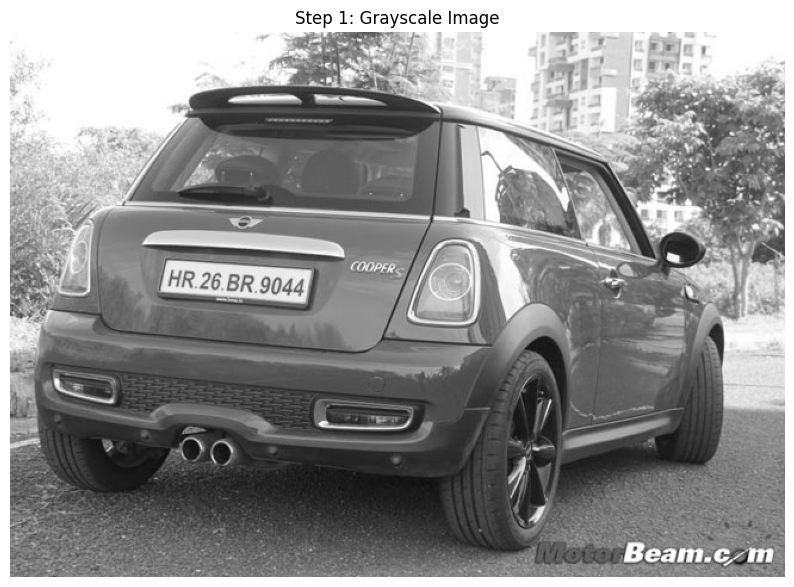

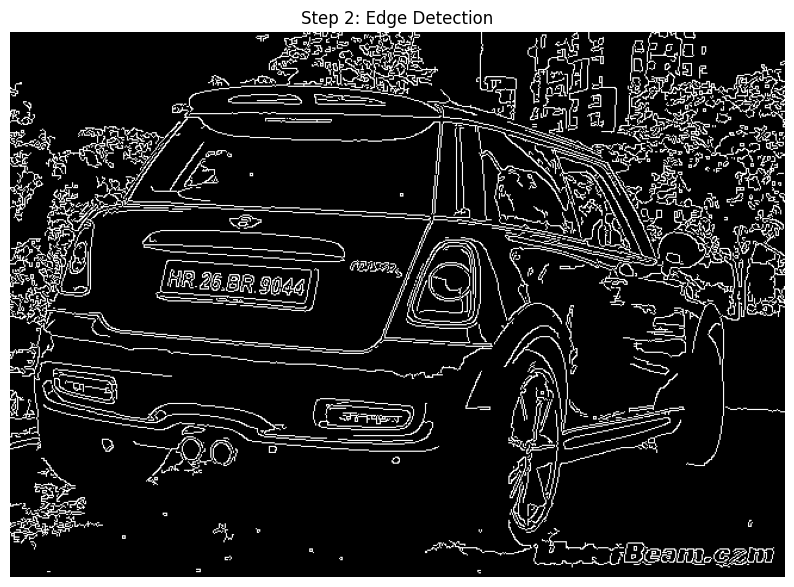

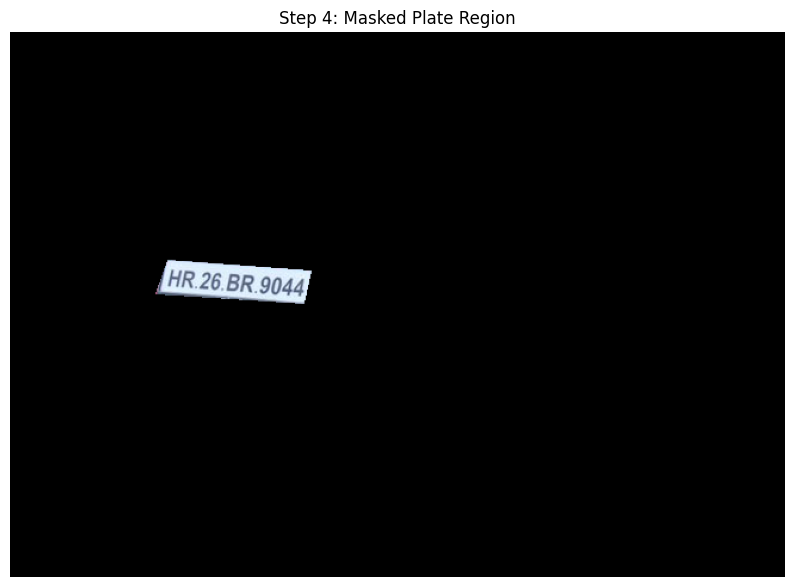

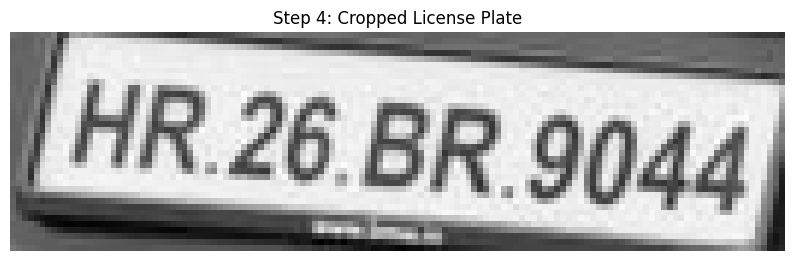

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


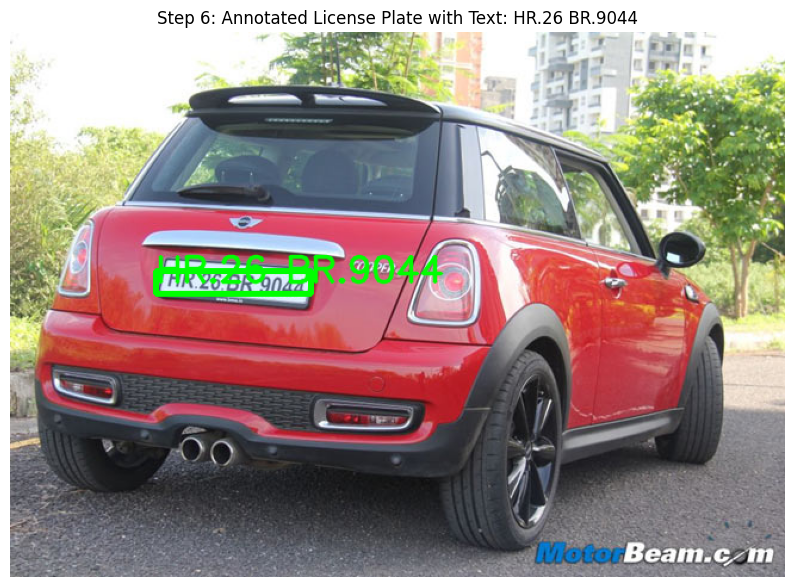

Detected License Plate Text: HR.26 BR.9044


In [51]:
recognize_license_plate("C:/Users/adity/Downloads/ANPRwithPython-main/ANPRwithPython-main/image1.jpg")

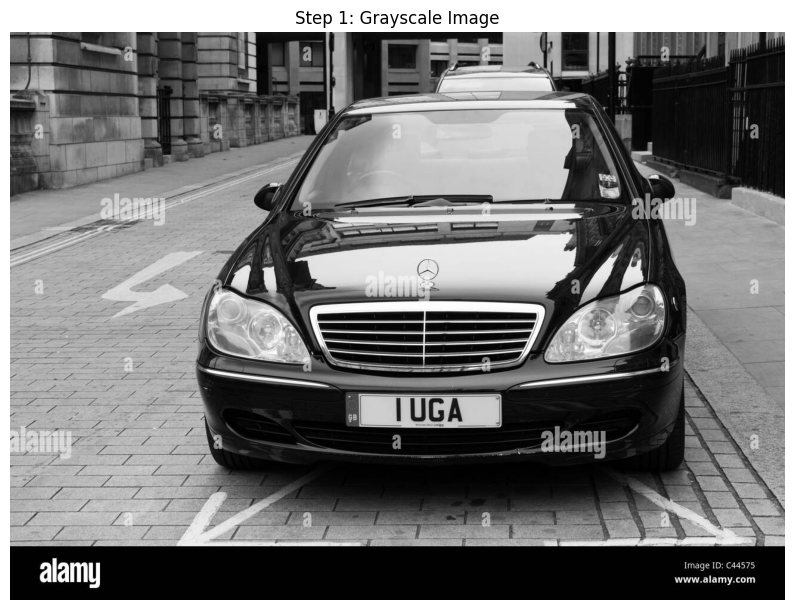

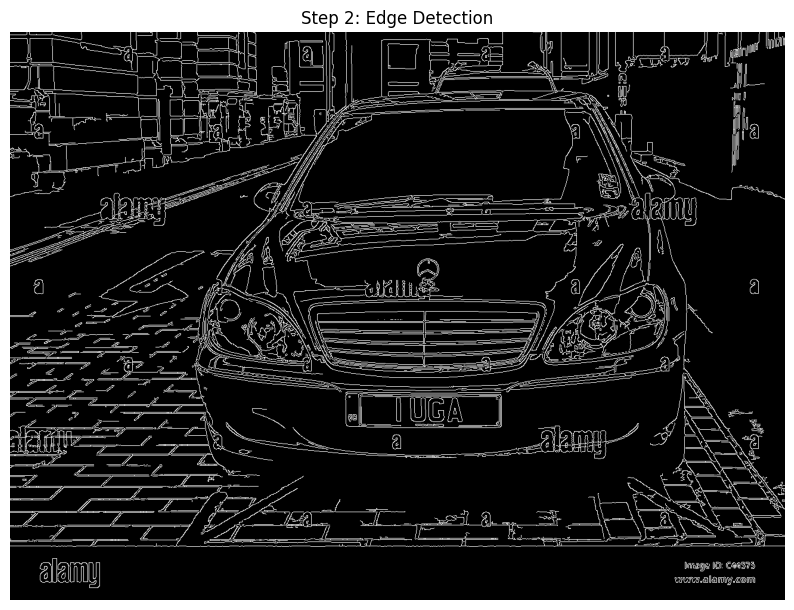

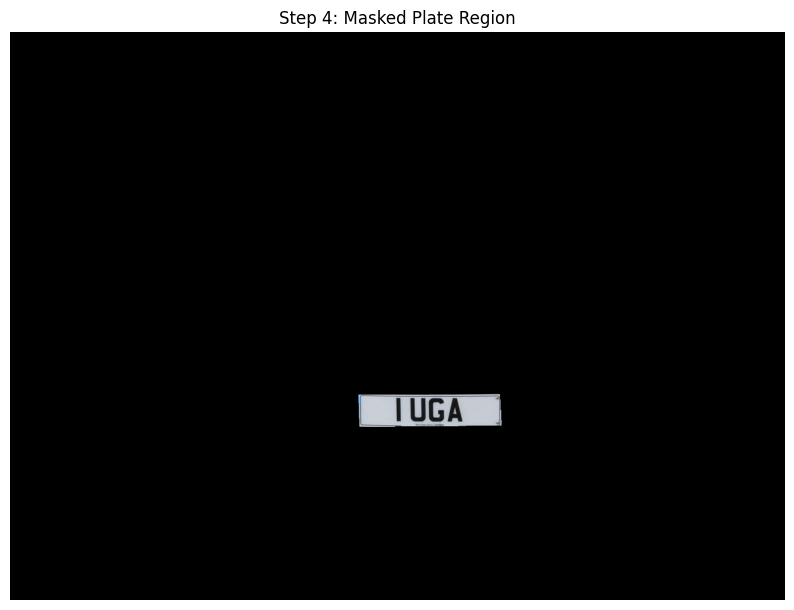

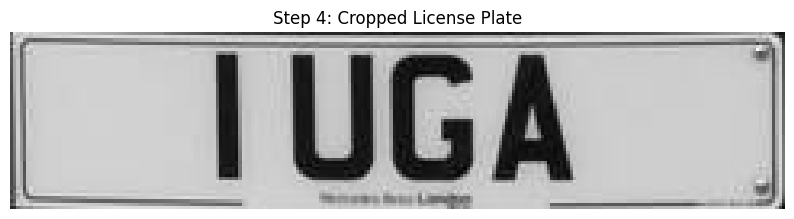

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


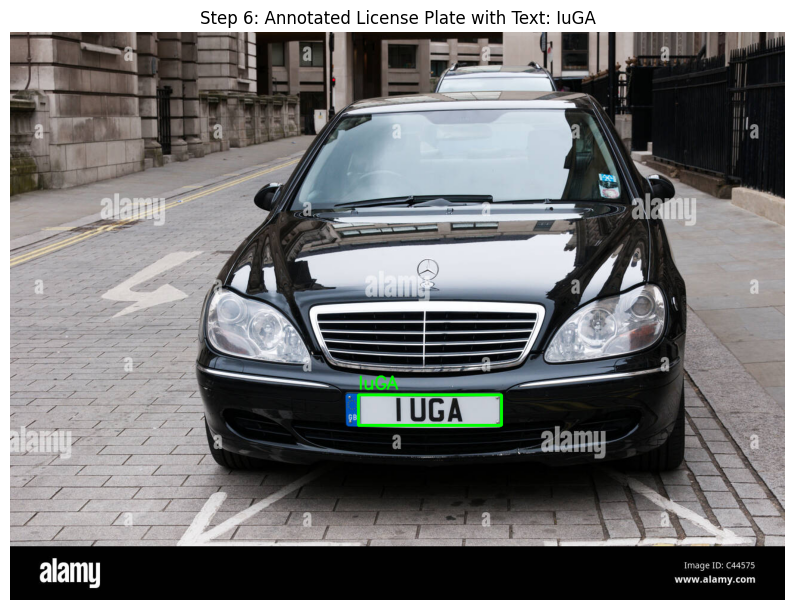

In [49]:
recognize_license_plate("C:/Users/adity/Downloads/img11.jpg")